In [1]:
import os
os.chdir('../../')
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle as pkl
matplotlib.rcParams.update({'font.size': 20})

INFO: Using pytorch backend


In [2]:
"""
model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/moons_GT_n05_lr-4/version_0/checkpoints/last.ckpt"
    )
"""
model = fff.FreeFormFlow.load_from_checkpoint(
    "lightning_logs/smoons/version_9/checkpoints/last.ckpt"
)

torch.Size([1000])
[32, 256, 256, 32]
[32, 256, 256, 32]
[32, 256, 256, 32]
2moons
cond_dim:  0
latent_dim:  1
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]


In [3]:
torch.set_grad_enabled(False)

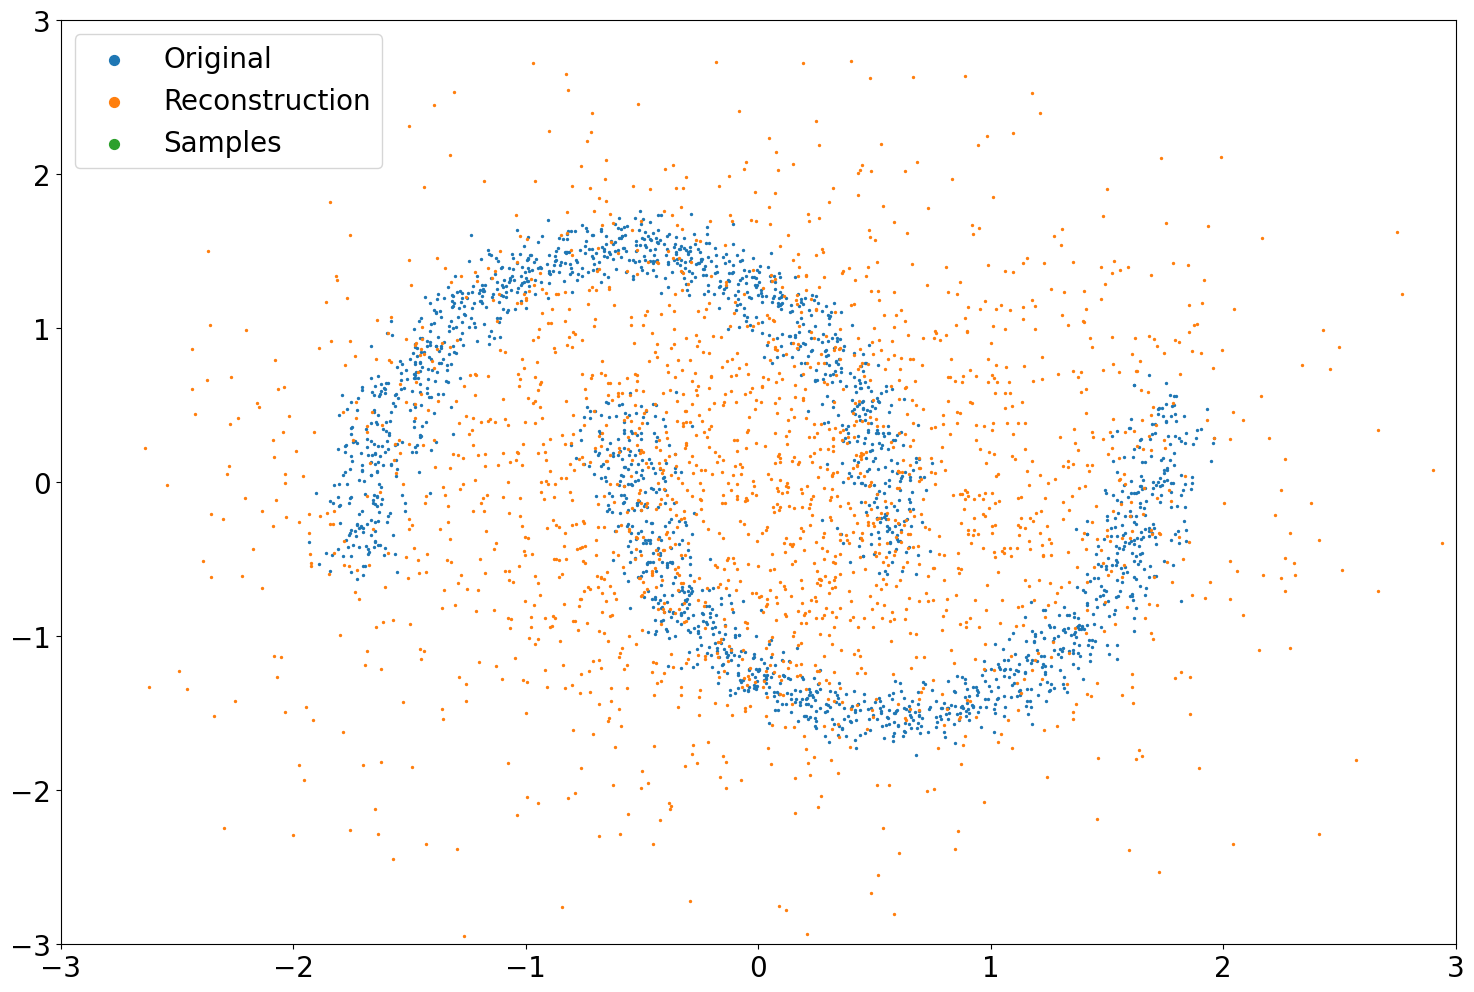

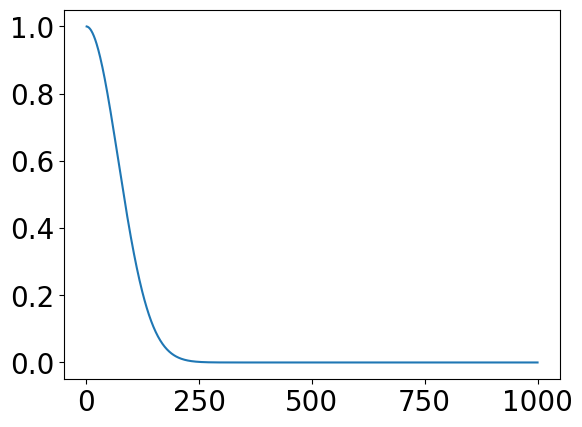

tensor([ 0.5804, -1.5345,  0.1423,  ..., -0.6418,  1.6451, -1.0182]) tensor([-1.6507,  0.6060,  1.1510,  ...,  1.4938, -0.3242,  1.3973])


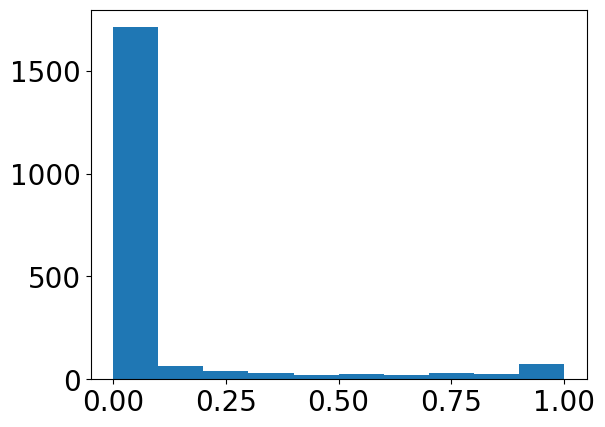

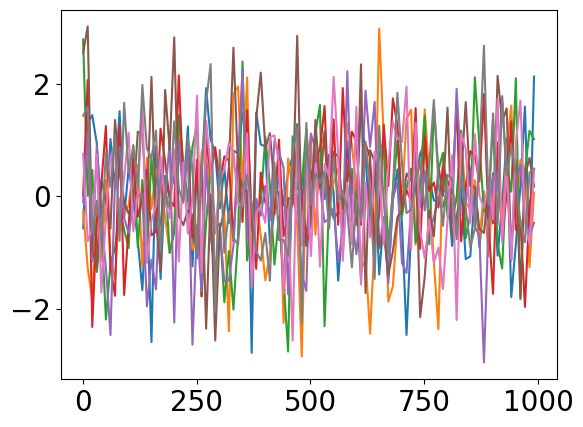

In [5]:
c_targets = plot_manifold(model)

In [4]:
from fff.evaluate.plots import all_conditions
def plot_manifold(rectangular_flow, condition=None):
    eps = 1e-12
    plt.figure(figsize=[18,12])
    data = {}

    train_batch = rectangular_flow.train_data[:2048]
    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c = conditioned.condition
    c_empt = torch.empty((c.shape[0], 0), dtype=c.dtype)
    device = rectangular_flow.device
    #print(train_samples.shape)

    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_empt.split(batch_size))
    ])
    
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c_empt.split(batch_size))
    ])

    #print(z_train.shape)
    t = torch.randint(0, 1000, (z_train.size(0),), device=device).long()
    z_diff, epsilon = rectangular_flow.diffuse(z_train.to(device), t, rectangular_flow.alphas_.to(device))
    
    z_test = torch.randn_like(z_train)
    x1_test = rectangular_flow.sample(torch.Size([2048]), c.to(device)).cpu()

    plt.scatter(*train_samples.T, s=2, label="Original")
    plt.scatter(*z_diff.cpu().T, s=2, label="Reconstruction")
    plt.scatter(*x1_test.T, s=2, label="Samples")

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend(markerscale=5.)
    plt.show()
    plt.close()

    betas = rectangular_flow.alphas_
    plt.plot(torch.linspace(1,1000,1000), betas)
    plt.show()
    print(*z_train.T)

    plt.hist(betas[t.cpu()])
    plt.show()
    time_embedding = torch.nn.Embedding(1000, 8)
    t = torch.arange(1,1000, step=10)
    plt.plot(t, time_embedding(t)[:,:])

In [6]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [17]:
from fff.evaluate.plots import all_conditions
def plot_manifold(rectangular_flow, condition=None):
    eps = 1e-12
    plt.figure(figsize=[18,12])
    data = {}

    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "data/"
    fileName = path + 'fif_moons'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()

    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c_t.split(batch_size))
    ])
    """
    t = torch.randint(0, 1000, (z_train.size(0),), device=device).long()
    z_diff, epsilon = rectangular_flow.diffuse(z_train.to(device), t, rectangular_flow.alphas_.to(device))
    """
    z_sample = torch.randn_like(z_train)
    x1_test = rectangular_flow.sample(torch.Size([6400])).cpu()

    plt.scatter(*train_samples.T, s=2, label="Original")
    #plt.scatter(*z_diff.cpu().T, s=2, label="Reconstruction")
    plt.scatter(*x1_test.T, s=2, label="Samples")

    x_train = train_samples
    N = 20
    for i in range(N):
        step = np.linspace(-2.5,2.5,N)
        mask1 = np.squeeze(z_train>step[i]-0.003)
        mask2 = np.squeeze(z_train<step[i]+0.003)
        mask = torch.logical_and(mask1, mask2)
        c=z_train[mask]
        x1 = x_train[mask]
        print(x1.shape[0])
        plt.scatter(*x1.T, s=2, color = "red")
        """
        if z_train.shape[-1] == 1:
            u_eq = torch.linspace(-1 + eps, 1 - eps, 100, dtype=torch.float64)[:, None]
            z_eq = torch.erfinv(u_eq).float()
            if condition is None:
                batch = (z_eq,)
            else:
                batch = (z_eq, torch.repeat_interleave(condition[None, :], len(z_eq), 0))

            conditioned_eq = rectangular_flow.apply_conditions(batch)
            z_eq = conditioned_eq.x_noisy
            c_eq = conditioned_eq.condition
            x_eq = rectangular_flow.decode(z_eq.to(device), c_eq.to(device)).cpu()

            z_full = torch.cat([
                -10 ** torch.linspace(2, -2, 10_000)[:, None],
                10 ** torch.linspace(-2, 2, 10_000)[:, None]
            ])
            if condition is None:
                batch = (z_full,)
            else:
                batch = (z_full, torch.repeat_interleave(condition[None, :], len(z_full), 0))
            conditioned_eq = rectangular_flow.apply_conditions(batch)
            z_full = conditioned_eq.x_noisy
            c_full = conditioned_eq.condition
            x_full = rectangular_flow.decode(z_full.to(device), c_full.to(device)).cpu()

            plt.plot(*x_full.T, "-", lw=1, label="Manifold")
            plt.plot(*x_eq.T, ".", ms=2, label="Equally spaced")
            """

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend(markerscale=5.)
    plt.show()
    plt.close()
    print(z_train.shape)
    a = np.linspace(-3,3,100)
    plt.hist(z_test.squeeze(), bins=100, density=True)
    plt.plot(a, normal(a))
    plt.show()
    """
    betas = rectangular_flow.alphas_
    plt.plot(torch.linspace(1,1000,1000), betas)
    plt.show()
    print(*z_train.T)

    plt.hist(betas[t.cpu()])
    plt.show()
    time_embedding = torch.nn.Embedding(1000, 8)
    t = torch.arange(1,1000, step=10)
    plt.plot(t, time_embedding(t)[:,:])
    """

In [11]:
c = c_targets[2].squeeze()
print(torch.min(c).item())
print(torch.max(c).item())

TypeError: 'NoneType' object is not subscriptable

In [14]:
from fff.evaluate.plots import all_conditions
def plot_cond_manifold(rectangular_flow):
    eps = 1e-12
    plt.figure(figsize=[18,12])

    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    val_samples = conditioned.x_noisy
    c = conditioned.condition

    device = rectangular_flow.device
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c.split(batch_size))
    ])
    print("decoding...")
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c.split(batch_size))
    ])
    z_test = torch.randn_like(z_train)
    print("decoding...")
    x1_test = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c.split(batch_size))
    ])
    print(x1_test.shape)

    plt.scatter(*val_samples.T, s=1, label="Original")
    plt.scatter(*x1_train.T, s=1, label="Reconstruction")
    plt.scatter(*x1_test.T, s=1, label="Samples")
    fibres, conditions = sample_fibres(rectangular_flow)
    print(fibres.shape)

    c_targets = []

    for i in range(conditions.shape[0]):
        r = 0.0005
        x1 = torch.Tensor([0])
        while x1.shape[0]<20 and r<0.01:
            mask1 = np.squeeze(c_train>conditions[i]-r)
            mask2 = np.squeeze(c_train<conditions[i]+r)
            mask = torch.logical_and(mask1, mask2)
            c_target=c_train[mask]
            x1 = train_samples[mask]
            r = r*1.1
            
        print(x1.shape[0])
        c_targets.append(c_target)
        plt.scatter(
                            x1[:,0],
                            x1[:,1],
                            s = 2,
                            c = "black",
                        )
    plt.scatter(
                [100],
                [100],
                s = 1,
                c = "black",
                label = "OrigFib",
                )

    plt.scatter(*fibres.T, s=1, c='red', label="Fibres")

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend(markerscale=5.)
    plt.savefig("fib_2m_small")
    plt.show()
    plt.close()

    plt.hist(*z_train.T, bins=60, label="Samples")
    plt.show()

    return c_targets

In [5]:
def sample_fibres(model, sub_resolution=100):
    samples = []
    pos_min, pos_max = -2.0, 2.0
    resolution = 50
    conditions = torch.linspace(pos_min, pos_max, resolution, device=model.device)
    latents = torch.randn([sub_resolution,1], device=model.device)
    for c in conditions:
        cond = c.repeat(latents.shape[0],1)
        samples.append(model.decode(latents, cond))
    x = torch.cat(samples, dim=0)
    return x.cpu().detach(), conditions.cpu().numpy()

In [56]:
plot_latent_codes_2d_1d(model)

NameError: name 'plot_latent_codes_2d_1d' is not defined

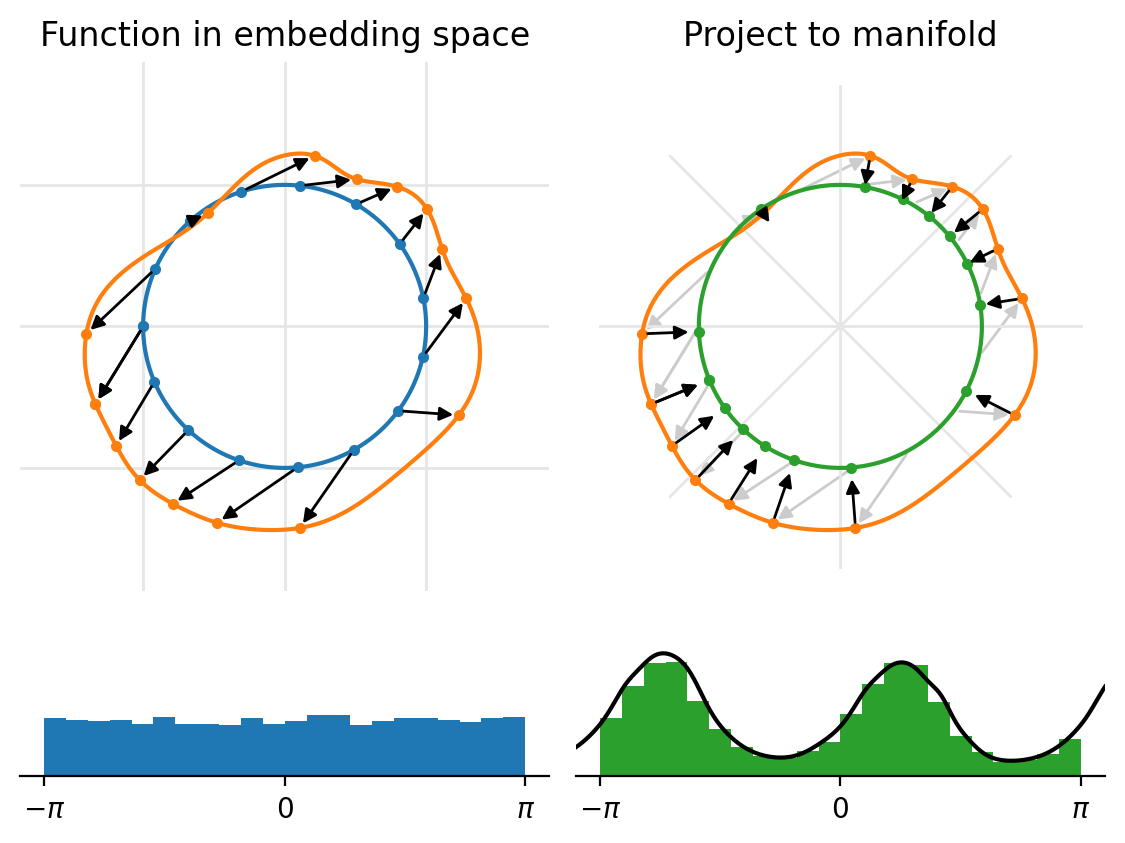

In [5]:
def euc_to_pol(x, distort=False):
    out = torch.stack([
        torch.atan2(x[:, 1], x[:, 0]),
        x.norm(2, -1)
    ], 1)
    if distort:
        # Exagerate deviations from circle
        out[:, 1] = (out[:, 1] - 1) * 3 + 1.3
    return out


def pol_to_euc(x):
    return x[:, 1:] * torch.stack([
        torch.cos(x[:, 0]),
        torch.sin(x[:, 0])
    ], 1)


fig, axes = plt.subplots(2, 2, sharex="row", sharey="row", figsize=(7, 5),
                         gridspec_kw=dict(height_ratios=[1, .2]))

# Generation process from equally spaced points in latent space
thetas_fine = torch.linspace(-torch.pi, torch.pi, 360)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
x1_fine = model.decode(batch.x0, batch.condition, project=False)
x1_proj_fine = model.manifold.projection(x1_fine)
x1_distorted_fine = pol_to_euc(euc_to_pol(x1_fine, True))
pol1_proj_fine = euc_to_pol(x1_proj_fine)

# Neural network acts in embedding
plt.sca(axes[0, 0])
plt.plot(*z_fine.T, label="Input data")
plt.plot(*x1_distorted_fine.T, label="Raw output")
subset = torch.linspace(0, len(thetas_fine) - 1, 16).long()
ms = 3
plt.plot(*z_fine[subset].T, "C0o", label="Selected raw output", ms=ms)
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
for x_in, x_out in zip(z_fine[subset], x1_distorted_fine[subset]):
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
plt.axis("off")
plt.title("Function in embedding space")
axes[0, 0].set_aspect(1)
for pos in [-1, 0, 1]:
    plt.axhline(pos, c=".9", zorder=-1, lw=1)
    plt.axvline(pos, c=".9", zorder=-1, lw=1)


# Projection to circle
plt.sca(axes[0, 1])
plt.title("Project to manifold")
plt.plot(*x1_distorted_fine.T, "C1", label="Raw output")
plt.plot(*x1_proj_fine.T, "C2", label="Projected output")
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
plt.plot(*x1_proj_fine[subset].T, "C2o", label="Selected raw output", ms=ms)
for x0, x_in, x_out in zip(
    z_fine[subset], x1_distorted_fine[subset], x1_fine[subset]
):
    plt.annotate("", x_in, x0, arrowprops=dict(
        arrowstyle='-|>', fc=".8", ec=".8"
    ), zorder=-1)
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
# Hint at polar projection using fake grid
for theta in torch.linspace(0, 2 * torch.pi, 8 + 1)[:-1]:
    plt.plot([0, 1.7 * np.cos(theta)], [0, 1.7 * np.sin(theta)], c=".9", zorder=-1, lw=1)

plt.axis("off")
axes[0, 1].set_aspect(1)

# Lower plots: Show histograms
count = 10_000
for ax, samples, color in zip(axes[1], [
    model.get_latent("cpu").sample((count,)),
    model.sample((count,)),
], ["C0", "C2"]):
    plt.sca(ax)
    ax.spines[["left", "top", "right"]].set_visible(False)
    plt.hist(euc_to_pol(samples)[:, 0], "auto", density=True, fc=color)
    plt.yticks([])
    plt.xticks([-np.pi, 0, np.pi], ["$-\\pi$", "$0$", "$\\pi$"])
    plt.xlim(-1.1 * np.pi, 1.1 * np.pi)

# Show density in lower left plot
plt.sca(axes[1, 1])
thetas_fine = torch.linspace(-1.1 * torch.pi, 1.1 * torch.pi, 300)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
probs = model.exact_log_prob(batch.x0, batch.condition).log_prob.exp()
plt.plot(thetas_fine, probs, "k")

# Adjust spacing
plt.subplots_adjust(wspace=.05, hspace=0)
# plt.savefig("m-fff-projection.pdf", bbox_inches="tight")